Updated Notebook from Practical Business Python.

Original article had a model that did not work correctly. This notebook is for the [updated article](http://pbpython.com/amortization-model-revised.html).

Many thanks to the individuals that helped me fix the errors. The solution below is based heavily on this [gist](https://gist.github.com/sjmallon/e1ca2aee4574d5517b8d31c93832222a) and comments on [reddit](https://www.reddit.com/r/Python/comments/5e3xab/building_a_financial_model_with_pandas/?st=iwjk8alv&sh=d721fcd7).

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import numpy_financial as npfin
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

Build a payment schedule using a generator that can be easily read into a pandas dataframe for additional analysis and plotting

In [2]:
def amortize(principal, interest_rate, years, pmt, addl_principal, start_date, annual_payments):
    """
    Calculate the amortization schedule given the loan details.

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param pmt: Payment amount per period
    :param addl_principal: Additional payments to be made each period.
    :param start_date: Start date for the loan.
    :param annual_payments: Number of payments in a year.

    :return: 
        schedule: Amortization schedule as an Ortdered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
    
    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = round(((interest_rate/annual_payments) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        pmt = min(pmt, beg_balance + interest)
        principal = pmt - interest
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        addl_principal = min(addl_principal, beg_balance - principal)
        end_balance = beg_balance - (principal + addl_principal)

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('Payment', pmt),
                           ('Principal', principal),
                           ('Interest', interest),
                           ('Additional_Payment', addl_principal),
                           ('End Balance', end_balance)])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance

Wrapper function to call `amortize`.

This function primarily cleans up the table and provides summary stats so it is easy to compare various scenarios.

In [3]:
def amortization_table(principal, interest_rate, years,
                       addl_principal=0, annual_payments=12, start_date=date.today()):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    
    :param annual_payments (optional): Number of payments in a year. DEfault 12.
    :param addl_principal (optional): Additional payments to be made each period. Default 0.
    :param start_date (optional): Start date. Default first of next month if none provided

    :return: 
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    # Payment stays constant based on the original terms of the loan
    payment = -round(npfin.pmt(interest_rate/annual_payments, years*annual_payments, principal), 2)
    
    # Generate the schedule and order the resulting columns for convenience
    schedule = pd.DataFrame(amortize(principal, interest_rate, years, payment,
                                     addl_principal, start_date, annual_payments))
    schedule = schedule[["Period", "Month", "Begin Balance", "Payment", "Interest", 
                         "Principal", "Additional_Payment", "End Balance"]]
    
    # Convert to a datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([payoff_date, schedule["Period"].count(), interest_rate,
                       years, principal, payment, addl_principal,
                       schedule["Interest"].sum()],
                       index=["Payoff Date", "Num Payments", "Interest Rate", "Years", "Principal",
                             "Payment", "Additional Payment", "Total Interest"])
    
    return schedule, stats

Example showing how to call the function

In [4]:
mortgage_value = 1100000
mortgage_apr = 0.0725
mortgage_term_yrs = 30
addl_principal_per_mo = 200

df, stats = amortization_table(mortgage_value, mortgage_apr, mortgage_apr, addl_principal=addl_principal_per_mo, start_date=date(2023, 1,1))

In [5]:
stats

Payoff Date           2023-01-01 00:00:00
Num Payments                            1
Interest Rate                      0.0725
Years                              0.0725
Principal                         1100000
Payment                        1271509.25
Additional Payment                    200
Total Interest                    6645.83
dtype: object

In [6]:
df.head()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
0,1,2023-01-01,1100000,1106645.83,6645.83,1100000.0,0.0,0.0


In [7]:
df.tail()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
0,1,2023-01-01,1100000,1106645.83,6645.83,1100000.0,0.0,0.0


Make multiple calls to compare scenarios

In [8]:
schedule1, stats1 = amortization_table(mortgage_value, mortgage_apr, mortgage_term_yrs, addl_principal=50, start_date=date(2023,1,1))
schedule2, stats2 = amortization_table(mortgage_value, mortgage_apr-.01, 30, addl_principal=200, start_date=date(2023,1,1))
schedule3, stats3 = amortization_table(mortgage_value, mortgage_apr, 15, addl_principal=0, start_date=date(2023,1,1))

In [9]:
pd.DataFrame([stats1, stats2, stats3])

,Payoff Date,Num Payments,Interest Rate,Years,Principal,Payment,Additional Payment,Total Interest
0,2052-04-01,352,0.0725,30,1100000,7503.94,50,1556727.17
1,2050-08-01,332,0.0625,30,1100000,6772.89,200,1213983.01
2,2038-01-01,181,0.0725,15,1100000,10041.49,0,707468.82


Make some plots to show scenarios

In [10]:
%matplotlib inline
plt.style.use('ggplot')

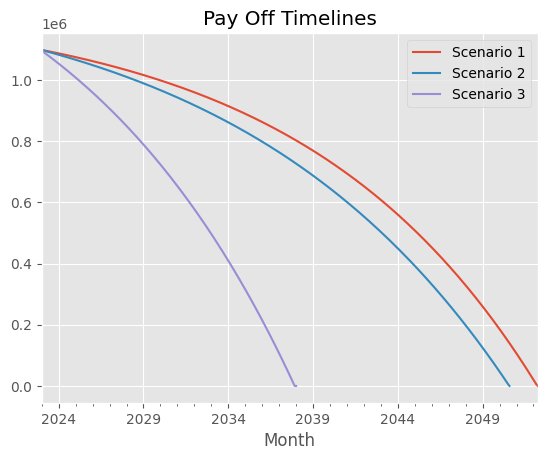

In [11]:
fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Month', y='End Balance', label="Scenario 1", ax=ax)
schedule2.plot(x='Month', y='End Balance', label="Scenario 2", ax=ax)
schedule3.plot(x='Month', y='End Balance', label="Scenario 3", ax=ax)
plt.title("Pay Off Timelines");

In [12]:
def make_plot_data(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label"""
    y = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    y["Year"] = y["Month"].dt.year
    y.set_index('Year', inplace=True)
    y.drop(columns=['Month'], inplace=True)
    label="{} years at {}% with additional payment of ${}".format(stats['Years'], round(stats['Interest Rate']*100,2), stats['Additional Payment'])
    return y, label
    
y1, label1 = make_plot_data(schedule1, stats1)
y2, label2 = make_plot_data(schedule2, stats2)
y3, label3 = make_plot_data(schedule3, stats3)

y = pd.concat([y1, y2, y3], axis=1)

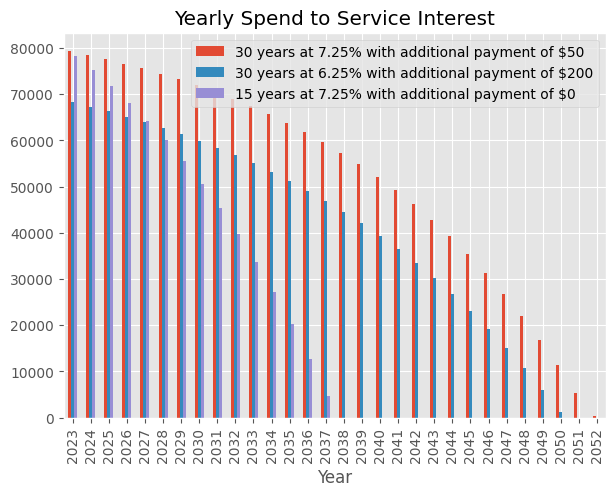

In [13]:
figsize(7,5)
fig, ax = plt.subplots(1, 1)
y.plot(kind="bar", ax=ax)

plt.legend([label1, label2, label3], loc=1, prop={'size':10})
plt.title("Yearly Spend to Service Interest");

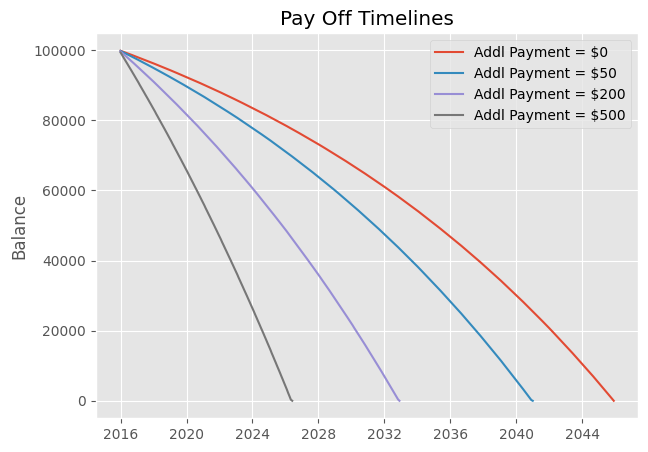

In [14]:
additional_payments = [0, 50, 200, 500]
fig, ax = plt.subplots(1, 1)

for pmt in additional_payments:
    result, _ = amortization_table(100000, .04, 30, addl_principal=pmt, start_date=date(2016,1,1))
    ax.plot(result['Month'], result['End Balance'], label='Addl Payment = ${}'.format(str(pmt)))
plt.title("Pay Off Timelines")
plt.ylabel("Balance")
ax.legend();